In [1]:
using JLD2
using Random

include("data_structures.jl");
include("plotting.jl");
include("object_aware_HDP.jl");

In [2]:
@load "train_test_splits.jld2" cat1_splits cat2_splits;

In [3]:
objects = [obj.percepts for obj in cat1_splits[50].train_objects_skewed]

hyper = ObjectAwareHDPHyperparams(
    m0    = [0.0, 0.0],
    k_clu = 1.0,
    k_obj = 5.0,
    k_per = 20.0,
    a0    = 1.0,
    b0    = 1.0,
    alpha = 1.0,
)

temp_z, temp_clu = object_aware_hdp_cluster_update(objects, hyper; iters = 5000);
length(unique(temp_z))

4

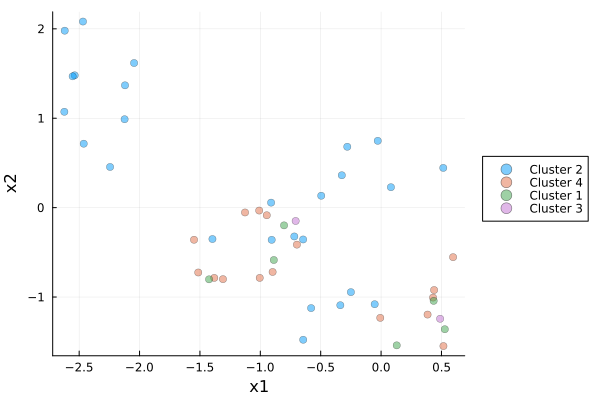

In [4]:
percepts = vcat((obj.percepts for obj in cat1_splits[50].train_objects_uniform)...);
z_for_percepts = [ temp_z[i]              # the object's z
                   for (i, obj) in enumerate(objects)
                   for _ in obj  # repeat once per percept
                 ]
v = unique(z_for_percepts)
p = sortperm(v)
rank = similar(v)
rank[p] = 1:length(v)
rankmap = Dict(v[i] => rank[i] for i in eachindex(v))
replaced_z = [ get(rankmap, val, val) for val in z_for_percepts ];
plot_clusters(percepts, replaced_z)

In [5]:
hyper = ObjectAwareHDPHyperparams(
    m0    = [0.0, 0.0],
    k_clu = 1.0,
    k_obj = 5.0,
    k_per = 20.0,
    a0    = 1.0,
    b0    = 1.0,
    alpha = 1.0,
)
n_splits = length(cat2_splits)
n_test_per_cat = 50
cat1_performance = Vector{Float64}(undef, n_splits)
cat2_performance = Vector{Float64}(undef, n_splits)

for i in 1:n_splits
    cat1_correct = cat2_correct = 0
    cat1_train = [obj.percepts for obj in cat1_splits[i].train_objects_uniform]
    cat2_train = [obj.percepts for obj in cat2_splits[i].train_objects_uniform]

    cat1_z, cat1_clu = object_aware_hdp_cluster_update(cat1_train, hyper; iters=1000)
    cat2_z, cat2_clu = object_aware_hdp_cluster_update(cat2_train, hyper; iters=1000)

    cat1_test = vcat((obj.percepts for obj in cat1_splits[i].test_objects)...)
    for j in 1:length(cat1_test)
        logp_test_given_cat1 = log_post_pred_y(cat1_test[j], cat1_clu, hyper)
        logp_test_given_cat2 = log_post_pred_y(cat1_test[j], cat2_clu, hyper)
        cat1_correct += logp_test_given_cat1 > logp_test_given_cat2
    end
    cat1_performance[i] = cat1_correct 

    cat2_test = vcat((obj.percepts for obj in cat2_splits[i].test_objects)...)
    for j in 1:length(cat2_test)
        logp_test_given_cat1 = log_post_pred_y(cat2_test[j], cat1_clu, hyper)
        logp_test_given_cat2 = log_post_pred_y(cat2_test[j], cat2_clu, hyper)
        cat2_correct += logp_test_given_cat1 < logp_test_given_cat2
    end 
    cat2_performance[i] = cat2_correct 
end 

println(cat1_performance ./ n_test_per_cat)
println(cat2_performance ./ n_test_per_cat)
println(mean(cat1_performance ./ n_test_per_cat), mean(cat2_performance ./ n_test_per_cat))
println(sum(cat1_performance .> cat2_performance))

[0.9, 0.94, 1.0, 0.94, 0.94, 0.94, 0.86, 0.98, 0.58, 0.98, 0.84, 0.98, 0.9, 0.98, 1.0, 0.96, 0.94, 0.7, 0.9, 0.98, 0.94, 0.94, 0.98, 0.9, 0.9, 0.84, 1.0, 1.0, 1.0, 0.88, 0.82, 1.0, 1.0, 1.0, 0.96, 0.7, 0.84, 0.92, 0.86, 0.96, 0.92, 1.0, 0.84, 0.9, 0.92, 0.82, 0.92, 0.88, 0.94, 1.0, 0.88, 0.88, 0.9, 0.86, 0.9, 0.94, 0.96, 0.94, 1.0, 0.98]
[0.84, 0.88, 0.98, 1.0, 0.9, 0.98, 0.9, 0.92, 1.0, 0.9, 0.86, 1.0, 0.88, 0.98, 0.98, 0.9, 0.92, 0.96, 0.86, 0.88, 0.9, 0.9, 0.98, 0.9, 0.92, 0.88, 0.8, 0.86, 0.86, 0.88, 0.88, 0.94, 1.0, 0.98, 0.84, 0.9, 0.88, 0.9, 0.88, 1.0, 0.86, 0.94, 1.0, 0.88, 0.9, 0.9, 0.98, 0.8, 0.94, 0.96, 0.92, 0.88, 0.96, 0.96, 0.94, 0.98, 0.96, 0.9, 0.96, 0.98]
0.91766666666666660.9199999999999998
29


In [6]:
hyper = ObjectAwareHDPHyperparams(
    m0    = [0.0, 0.0],
    k_clu = 1.0,
    k_obj = 5.0,
    k_per = 20.0,
    a0    = 1.0,
    b0    = 1.0,
    alpha = 1.0,
)
n_splits = length(cat2_splits)
n_test_per_cat = 50
cat1_performance = Vector{Float64}(undef, n_splits)
cat2_performance = Vector{Float64}(undef, n_splits)

for i in 1:n_splits
    cat1_correct = cat2_correct = 0
    cat1_train = [obj.percepts for obj in cat1_splits[i].train_objects_skewed]
    cat2_train = [obj.percepts for obj in cat2_splits[i].train_objects_skewed]

    cat1_z, cat1_clu = object_aware_hdp_cluster_update(cat1_train, hyper; iters=1000)
    cat2_z, cat2_clu = object_aware_hdp_cluster_update(cat2_train, hyper; iters=1000)

    cat1_test = vcat((obj.percepts for obj in cat1_splits[i].test_objects)...)
    for j in 1:length(cat1_test)
        logp_test_given_cat1 = log_post_pred_y(cat1_test[j], cat1_clu, hyper)
        logp_test_given_cat2 = log_post_pred_y(cat1_test[j], cat2_clu, hyper)
        cat1_correct += logp_test_given_cat1 > logp_test_given_cat2
    end
    cat1_performance[i] = cat1_correct 

    cat2_test = vcat((obj.percepts for obj in cat2_splits[i].test_objects)...)
    for j in 1:length(cat2_test)
        logp_test_given_cat1 = log_post_pred_y(cat2_test[j], cat1_clu, hyper)
        logp_test_given_cat2 = log_post_pred_y(cat2_test[j], cat2_clu, hyper)
        cat2_correct += logp_test_given_cat1 < logp_test_given_cat2
    end 
    cat2_performance[i] = cat2_correct 
end 

println(cat1_performance ./ n_test_per_cat)
println(cat2_performance ./ n_test_per_cat)
println(mean(cat1_performance ./ n_test_per_cat), mean(cat2_performance ./ n_test_per_cat))
println(sum(cat1_performance .> cat2_performance))

[0.94, 0.94, 1.0, 1.0, 0.92, 0.86, 0.88, 0.96, 0.8, 0.98, 0.94, 0.96, 0.86, 1.0, 1.0, 0.96, 0.94, 0.76, 0.96, 0.98, 0.78, 0.94, 0.96, 0.92, 0.92, 0.86, 1.0, 1.0, 0.96, 0.84, 0.82, 0.8, 0.96, 0.98, 0.9, 0.78, 0.86, 0.98, 0.86, 0.96, 0.92, 0.92, 0.9, 0.9, 0.84, 0.92, 0.68, 0.88, 0.9, 1.0, 0.94, 0.96, 0.88, 0.94, 0.92, 1.0, 0.98, 0.94, 1.0, 0.96]
[0.88, 0.88, 1.0, 1.0, 0.9, 1.0, 0.9, 0.98, 1.0, 0.84, 0.88, 1.0, 0.92, 1.0, 0.98, 0.9, 1.0, 0.98, 0.9, 0.9, 0.96, 0.9, 1.0, 0.9, 0.8, 0.86, 0.9, 0.94, 0.9, 0.88, 0.88, 0.8, 1.0, 1.0, 0.86, 0.88, 0.86, 0.88, 0.88, 0.96, 0.8, 1.0, 0.92, 0.88, 0.9, 0.9, 1.0, 0.84, 1.0, 0.92, 0.88, 0.88, 1.0, 1.0, 0.88, 0.96, 0.98, 0.9, 0.88, 1.0]
0.91833333333333320.9233333333333333
28
